In [0]:
import pandas as pd
import numpy as np

#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 
from sklearn.feature_extraction.text import CountVectorizer

# 
import random
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor

# 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Flatten, LSTM, Dense, Dropout
from keras.models import Sequential, Model
from keras.utils import plot_model


## 1. Load data

In [3]:
#importing clean text 
data = pd.read_csv('preprocessed_data.csv')
data.head()

,city,average_cost_for_two,has_table_booking,has_online_delivery,is_delivering_now,aggregate_rating,votes,review,word_count
0,Yorkton,25,0,0,0,3.3,26,love arigato sushi best restaurant yorkton alw...,247
1,Lucknow,800,0,0,0,4.6,567,simply love placeit ideal breakfastlunchdinner...,99
2,Vernonia,10,0,0,0,4.3,88,delicious theres single dish ive tried blue ho...,55
3,Mayfield,20,0,0,0,2.9,11,lot food many varieties sushi fresh love many ...,306
4,Guwahati,400,0,0,0,4.1,377,th avenue cafe always favoriteloved cheesy mea...,48


## 2. Models

### 3.1 Converting to dummy variables

In [4]:
# pd.get_dummies ==> Convert categorical variable into dummy/indicator variables.(OneHot encoding)

data['has_table_booking']= pd.get_dummies(data.has_table_booking, drop_first=True)
data['has_table_booking']= pd.get_dummies(data.has_table_booking, drop_first=True)
data['is_delivering_now']= pd.get_dummies(data.is_delivering_now, drop_first=True)

data.head() 

,city,average_cost_for_two,has_table_booking,has_online_delivery,is_delivering_now,aggregate_rating,votes,review,word_count
0,Yorkton,25,0,0,0,3.3,26,love arigato sushi best restaurant yorkton alw...,247
1,Lucknow,800,0,0,0,4.6,567,simply love placeit ideal breakfastlunchdinner...,99
2,Vernonia,10,0,0,0,4.3,88,delicious theres single dish ive tried blue ho...,55
3,Mayfield,20,0,0,0,2.9,11,lot food many varieties sushi fresh love many ...,306
4,Guwahati,400,0,0,0,4.1,377,th avenue cafe always favoriteloved cheesy mea...,48


In [0]:
# #  cuisines converted to categorical features
# data['cuisines'] = data['cuisines'].astype(str).apply(lambda x: ' '.join(sorted(x.split())))
# data['cuisines'].value_counts().head()

In [0]:
data = data.rename(columns={
    'average_cost_for_two':'average_cost',
    'aggregate_rating':'rate'
    })

## 3.2 Splitting data for Model Building

In [0]:
# build x & y dataset
x = data.drop(['aggregate_rating'],axis = 1)
y = data['aggregate_rating']

In [8]:
x.shape, y.shape

((840, 8), (840,))

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 33)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((588, 8), (252, 8), (588,), (252,))

In [0]:
# One hot encoder
enc = OneHotEncoder( handle_unknown='ignore')

In [0]:
## ALWAYS AVOID DATA LEAKAGE

# this method is for training data set
def one_hot_fit_transform(df,name):
    output_data = df[name].values.reshape(-1, 1)
    return enc.fit_transform(output_data).toarray()

# this method is for test data set
def one_hot_transform(df,name):
    output_data1 = df[name].values.reshape(-1, 1)
    return enc.transform(output_data1).toarray()

In [0]:
# one hot encoding apply to  features on train/test dataset
tr_dummy_rating_text = one_hot_fit_transform(X_train,'review' )
te_dummy_rating_text = one_hot_transform(X_test,'review' )

# one hot encoding apply to 'city' features on train/test dataset
tr_dummy_city = one_hot_fit_transform(X_train,'city' )
te_dummy_city= one_hot_transform(X_test,'city')

# one hot encoding apply to 'cuisines' features on train/test dataset
# tr_dummy_cuisines = one_hot_fit_transform(X_train,'cuisines' )
# te_dummy_cuisines = one_hot_transform(X_test,'cuisines')

In [15]:
tr_dummy_rating_text.shape, te_dummy_rating_text.shape

((588, 588), (252, 588))

In [17]:
tr_dummy_city.shape, te_dummy_city.shape

((588, 17), (252, 17))

In [18]:
## combine all 'one-hot' encoded features as Tr.
tr =pd.DataFrame(pd.np.column_stack([ tr_dummy_rating_text,tr_dummy_city]))

l1=X_train.values.tolist()
l2=tr.values.tolist()

for i in range(len(l1)):
    l1[i].extend(l2[i])

X_train=pd.DataFrame(l1,columns=X_train.columns.tolist()+tr.columns.tolist())
X_train.shape

(588, 613)

In [19]:
## combine all 'one-hot' encoded features as Te.
te =pd.DataFrame(pd.np.column_stack([ te_dummy_rating_text,te_dummy_city]))

l3=X_test.values.tolist()
l4=te.values.tolist()
for i in range(len(l3)):
    l3[i].extend(l4[i])

X_test=pd.DataFrame(l3,columns=X_test.columns.tolist()+te.columns.tolist())
X_test.shape

(252, 613)

In [0]:
# after onehot encoding DONE. 'city',''review' are redundant features. REMOVE them.

X_train =X_train.drop(['city','review'],axis = 1)
X_test =X_test.drop(['city','review'],axis = 1)

In [21]:
X_train.head(2)

,average_cost_for_two,has_table_booking,has_online_delivery,is_delivering_now,votes,word_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604
0,550,0,1,0,21,97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,500,0,1,0,167,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((588, 611), (252, 611), (588,), (252,))

In [0]:
from sklearn.metrics import  make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


def mse(y, y_pred):
    return np.mean((y_pred - y)**2) 

mse_scorer = make_scorer(mse, greater_is_better=False)

## Building Random Model(For Worst case MSE)

In [24]:
import random

rand_pred= np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    rand_probs = round(random.uniform(1.0, 5.0),2)
    rand_pred[i] = rand_probs

mse(y_test, rand_pred)

2.9148301587301573

Here we can see that random model provide 2.53 MSE value. We can take this as a cut off. Any model which has MSE less than random model is considered as better model.

## Model -1 Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

mse(y_test, y_pred_lr)

1.1258757460313247

## Model -2 Random Forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

0.14153352777777767

### Feature Importance

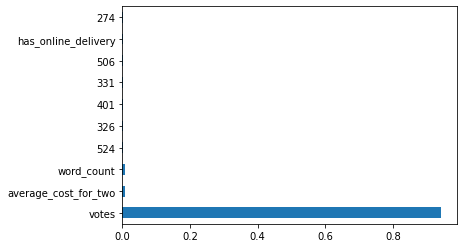

In [27]:
import matplotlib.pyplot as plt

#plot graph of feature importances for better visualization
feat_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [28]:
tuned_parameters = {'n_estimators': [150]}

grd_regressor = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10, 
                   n_jobs=-1, verbose=1, scoring=mse_scorer)
grd_regressor.fit(X_train, y_train)

y_pred_grd = grd_regressor.predict(X_test)

mse(y_test, y_pred_grd)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.9s finished


0.14094641269841268

After above experiment we got below result

- MSE:  0.04004986221340383 == 50(n_estimators)
- MSE:  0.03807506691137555 == 100 (n_estimators)
- MSE:  0.0377001297623944 == 150 (n_estimators)
- MSE:  0.03828087737268492 ==200(n_estimators)
- MSE:  0.03799677087809369 ===500 (n_estimators)

Final n_estimators choose 150


### Best Parameter Model

In [29]:

rfr = RandomForestRegressor(max_depth=None,n_estimators=150,min_samples_split= 2)
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

0.1421450246913582

In [30]:
Randpred = pd.DataFrame({ "actual": y_test, "pred": y_pred_rfr })
Randpred

,actual,pred
660,0.0,0.000000
622,3.7,3.753333
645,0.0,0.000000
286,3.1,3.037333
457,2.8,3.636000
...,...,...
170,3.2,3.037333
42,4.0,3.876000
516,4.1,3.956000
184,3.2,3.368000


### MSE = 0.0377 , It is good Model still can we still improved Model?

## Model 3: Natural Language Processing

### 3.1 NLP on review data

In [0]:
data_nlp = pd.read_csv('preprocessed_data.csv')


In [33]:
data_nlp.head()

,city,average_cost_for_two,has_table_booking,has_online_delivery,is_delivering_now,aggregate_rating,votes,review,word_count
0,Yorkton,25,0,0,0,3.3,26,love arigato sushi best restaurant yorkton alw...,247
1,Lucknow,800,0,0,0,4.6,567,simply love placeit ideal breakfastlunchdinner...,99
2,Vernonia,10,0,0,0,4.3,88,delicious theres single dish ive tried blue ho...,55
3,Mayfield,20,0,0,0,2.9,11,lot food many varieties sushi fresh love many ...,306
4,Guwahati,400,0,0,0,4.1,377,th avenue cafe always favoriteloved cheesy mea...,48


In [34]:

y = data_nlp['aggregate_rating']
X = data_nlp.drop(['aggregate_rating', 'city', 'average_cost_for_two', 'has_table_booking', 'has_online_delivery', 'is_delivering_now', 'votes','word_count'],axis = 1)


# Splitting into x and y into train and test set
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Splitting train set into tr and cv set
x_tr, x_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size = 0.2,random_state = 42)

x_tr_txt = x_tr['review']
x_cv_txt = x_cv['review']
x_test_txt = x_test['review']

print(x_tr_txt.shape,y_tr.shape )
print(x_cv_txt.shape,y_cv.shape )
print(x_test_txt.shape,y_test.shape )

(537,) (537,)
(135,) (135,)
(168,) (168,)


In [35]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=10) #in scikit-learn
# train data
X_train_bow = count_vect.fit_transform(x_tr_txt)

# test data
x_cv_bow = count_vect.transform(x_cv_txt)
x_test_bow = count_vect.transform(x_test_txt)


print('X_train_bow',X_train_bow.shape)
print('==='*10)
print('x_cv_bow',x_cv_bow.shape)
print('==='*10)
print('x_test_bow',x_test_bow.shape)

X_train_bow (537, 856)
x_cv_bow (135, 856)
x_test_bow (168, 856)


### Linear regression on review

In [36]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_bow,y_tr)
y_pred_lr = lr.predict(x_cv_bow)

mse(y_cv, y_pred_lr)

13.277268709073342

### Random Forest on review

In [37]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train_bow,y_tr)
y_pred_rfr = rfr.predict(x_cv_bow)

mse(y_cv, y_pred_rfr)

1.663500711111111

### LSTM Model

In [38]:
# 
X = data_nlp['review']
y = data_nlp['aggregate_rating']

# split the data set into train and test
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0, shuffle=True)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(588,) (252,) (588,) (252,)


In [39]:

max_review_length = 600
top_words = 10000

## pass through tokenizer
tk = Tokenizer(lower = True, num_words= top_words)
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)

## add padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_review_length)
X_test_seq = tk.texts_to_sequences(x_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_review_length)

print('train data shape ', X_train_pad.shape)
print('test data shape', X_test_pad.shape)

train data shape  (588, 600)
test data shape (252, 600)


In [40]:
# create the model
embedding_vecor_length = 256
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(200))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 256)          2560256   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               365600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 2,926,057
Trainable params: 2,926,057
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), 
                    epochs=20, 
                    verbose=1
                    )

Train on 588 samples, validate on 252 samples
Epoch 1/20
588/588 [==============================] - 20s 34ms/step - loss: 4.5421 - val_loss: 1.6911
Epoch 2/20
588/588 [==============================] - 18s 30ms/step - loss: 1.7364 - val_loss: 1.6310
Epoch 3/20
588/588 [==============================] - 18s 30ms/step - loss: 1.1149 - val_loss: 1.7189
Epoch 4/20
588/588 [==============================] - 17s 29ms/step - loss: 0.4545 - val_loss: 1.7837
Epoch 5/20
588/588 [==============================] - 18s 30ms/step - loss: 0.2750 - val_loss: 1.7644
Epoch 6/20
588/588 [==============================] - 18s 30ms/step - loss: 0.1977 - val_loss: 1.7289
Epoch 7/20
588/588 [==============================] - 17s 30ms/step - loss: 0.1944 - val_loss: 1.7976
Epoch 8/20
588/588 [==============================] - 18s 30ms/step - loss: 0.1724 - val_loss: 1.7694
Epoch 9/20
588/588 [==============================] - 17s 29ms/step - loss: 0.1782 - val_loss: 1.8158
Epoch 10/20
588/588 [===============

In [42]:
# evaluate the model
train_mse = model.evaluate(X_train_pad, y_train, verbose=0)
test_mse = model.evaluate(X_test_pad, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.034, Test: 1.849


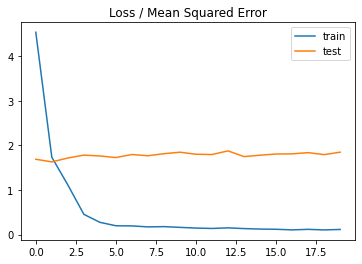

In [43]:
# # plot loss during training

plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Observation



# **Model Comparision**